In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

In [3]:
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado


# Preprocesamiento

## Conversión de variables

Hay que convertir todos los features categóricos a números. Para variables categóricas se usarán Dummy Variables y para ordinales OrdinalEncoder.

In [5]:
import preprocessing

X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.ordinal_encode(X)
X = preprocessing.dummy_variables(X)

## Selección de variables: Embedding

In [39]:
import preprocessing
from sklearn.tree import DecisionTreeClassifier

y = df.tiene_alto_valor_adquisitivo
clf = DecisionTreeClassifier(random_state=117)
X = preprocessing.embedded(X, y, clf, min_importance=0.05)
X.head()

,anios_estudiados,ganancia_perdida_declarada_bolsa_argentina,estado_marital_matrimonio_civil
0,17,2174,0
1,17,0,1
2,13,0,0
3,11,0,1
4,17,0,1


TODO: 
- filtrar la variable de educación alcanzada por la alta correlación con los años estudiados?
-  ¿Reducción dimensional?

# Árbol de decisión

## Entrenamiento y búsqueda de hiperparámetros

TODO:
- Evitar overfitting (poda, criterio de parada) -> Minimos y maximos para los hiperparametros?
- Criterio para elegir mejor combinacion de hiperparametros?  Cant de iteraciones?




Se usa RandomSearch para buscar la mejor combinación de hiperparámetros. Se elige la mejor combinación según su score de la curva ROC-AUC. 

In [35]:
from sklearn.model_selection import RandomizedSearchCV 
from sklearn import tree

y = df.tiene_alto_valor_adquisitivo

clf = tree.DecisionTreeClassifier(random_state=117)
params = {'max_depth': np.arange(1, 9), 'min_samples_leaf': np.arange(1, 16)}

metricas = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

rscv = RandomizedSearchCV(
    clf, params, n_iter=60, scoring=metricas, n_jobs=-1, cv=5, return_train_score=True, refit = 'roc_auc'
).fit(X, y)

rscv.best_params_

{'min_samples_leaf': 10, 'max_depth': 8}

# Métricas


Curva AUC-ROC, Accuracy, Precision, Recall, F1 score:

In [25]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, f1_score, recall_score

def calcular_metricas(y_true, y_pred):
    roc = roc_curve(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, pos_label=0)
    f1score = f1_score(y_true, y_pred)
    return (accuracy, precision, recall, f1score, roc)

Accuracy: 0.8591873713952274 
Precision: 0.8097412480974124 
Recall: 0.959546925566343 
F1-score: 0.649919828968466 
Curva ROC-AUC:


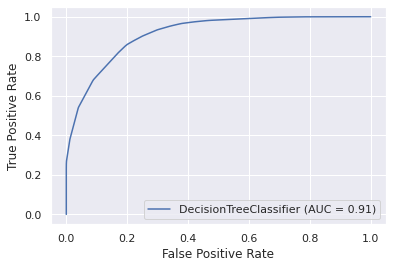

In [36]:
from sklearn.metrics import plot_roc_curve

(accuracy, precision, recall, f1score, roc) = calcular_metricas(y, rscv.best_estimator_.predict(X))
print(f"Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF1-score: {f1score} \nCurva ROC-AUC:")
roc = plot_roc_curve(rscv.best_estimator_, X, y)